# Natural Language Processing Assignment: Spam Filter
## Import necessary libs and datasets

In [2]:
import numpy as np
import pandas as pd
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from collections import Counter, OrderedDict

In [3]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data['text'] = data['v2']
data['isSpam'] = data['v1']

del data['v1'], data['v2']

print(f'Data Shape: {data.shape}')
# imbalanced data
print(data['isSpam'].value_counts())
data.head()

Data Shape: (5572, 2)
0    4825
1     747
Name: isSpam, dtype: int64


,text,isSpam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


## train, test split
### 평가에 사용할 예정이니 트레인, 테스트 스플릿 코드는 그대로 유지시켜주세요

In [4]:
from sklearn.model_selection import train_test_split

X, y = data['text'], data['isSpam']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,
                                                   stratify=y, test_size=0.1)

print(len(X_train), len(X_test))

5014 558


In [5]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

## Preprocessing
### 텍스트 전처리함수입니다.

In [6]:
def preprocess(string: str, *args, **kwargs):
    string = re.sub(r'(\w)\1{2,}', r'\1\1', string)
    string = re.sub(r"[^가-힣A-Za-z0-9()]", " ", string)     # 한글, 영문, 숫자, 괄호, 쉼표, 느낌표, 물음표, 작음따옴표, 역따옴표 제외한 나머지 모두 찾아서 공백(" ")으로 바꾸기
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\s'{2,}", "\'", string)
    string = re.sub(r"\'", "", string) 
    string = string.strip()                         


    return string.lower()


In [7]:
preprocess('Helllllo World-!')

'hello world'

#### 앞에서 보셨다시피 raw text를 그대로 사용하기엔 무리가 있습니다.(특수기호 및 불용어 문제 등)
#### 따라서 전처리되지 않은 raw string을 전처리하는 함수를 만들어주세요. <br>
```python
preprocess('Helllllo World-!') = 'hello world'
```
<br>

#### ```re``` library를 이용해서 전처리를 쉽게 할 수 있습니다.


[re documentation](https://docs.python.org/3/library/re.html)

## Tokenizing
### 전처리된 텍스트를 토크나이징 해주는 함수입니다.
#### ```SpaCy, nltk``` 등 영어 tokenizing 라이브러리를 쓰셔도 괜찮습니다.

In [8]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

def tokenize(string: str, *args, **kwargs) -> list:

    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(string) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return filtered_text 

In [9]:

import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
tokenize(preprocess('hello world!'))

['hello', 'world']

<br>

Ex) 
```python
tokenize('hello world!',  *args, **kwargs) = ['hello', 'world']
```

## Build Vocabulary
### 토큰들을 이용해서 자주 등장한 순서대로 n개의 원소를 갖는 딕셔너리를 만들어주세요.

In [11]:
from collections import Counter, OrderedDict

def build_vocab(n, words, **kwargs):
    wordfreq = dict(Counter(words).most_common(n-2))

    vocab = OrderedDict()
    vocab['padding_idx'] = 0
    vocab['unk_idx'] = 1

    idx = 2
    for word in wordfreq.keys():
      vocab[word] =  idx
      idx += 1

    return vocab

In [12]:
vocab = build_vocab(4,tokenize(preprocess('hello world!')))
vocab

OrderedDict([('padding_idx', 0), ('unk_idx', 1), ('hello', 2), ('world', 3)])

<br>

Ex) 
```python
vocab = build_vocab(4, *args, **kwargs)
vocab = {'padding_idx': 0, 'unk_idx': 1, 'hello': 2, 'world': 3}
```

#### 여기서 ```padding_idx```는 패딩에 쓰이는 인덱스, ```unk_idx```는 unknown token을 의미합니다.

### toTensor
#### 토큰들을 텐서로 바꿔주는 함수입니다.

In [13]:


import matplotlib.pyplot as plt

최대 길이 : 910
최소 길이 : 2
평균 길이 : 80.118808


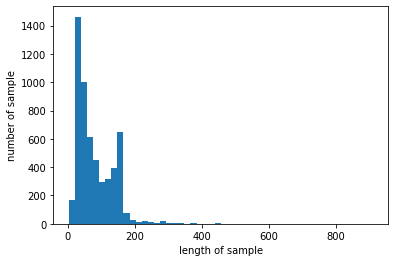

In [14]:

max_len = max(len(l) for l in X)
print('최대 길이 : %d' % max_len)
print('최소 길이 : %d' % min(len(l) for l in X))
print('평균 길이 : %f' % (sum(map(len, X))/len(X)))
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [15]:
def toTensor(max_len, words, vocab) -> torch.LongTensor:
  vocab = vocab
  max_len = max_len
  tokenized = list(map(preprocess,words))
  temp = []
  for w in tokenized: #각 줄에서 1개씩 글자를 읽음
      try:
        temp.append(vocab[w]) # 글자를 해당되는 정수로 변환
      except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
        temp.append(vocab['unk_idx']) # unk의 인덱스로 변환

  if len(temp) < max_len: 
      temp += [vocab['padding_idx']] * (max_len - len(temp)) 
  
  tensor = torch.FloatTensor(temp)
  return tensor.type(torch.LongTensor)
      

In [16]:
toTensor(5, ['hello', 'world!', 'yonsei'],vocab)

tensor([2, 3, 1, 0, 0])

시퀀스의 max length가 5일 때 다음과 같습니다.
<br>

Ex)
```python
toTensor(5, ['hello', 'world!', 'yonsei']) = torch.LongTensor([2, 3, 1, 0, 0])
```

여기서 ```yonsei``` 단어는 아까 만든 단어장(vocab)에 포함되지 않은 단어로 ```unk_idx```로 처리됩니다.

### 위의 함수들을 이용하고 적절한 코드 및 parameter를 적용해서 
### MailDataset과 train에 쓸 DataLoader를 만들어주세요.

In [17]:
class MailDataset(Dataset):

    def __init__(self):
        urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
        data = pd.read_csv('spam.csv', encoding='latin1')
        del data['Unnamed: 2']
        del data['Unnamed: 3']
        del data['Unnamed: 4']

        data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
        data['text'] = data['v2']
        data['isSpam'] = data['v1']

        del data['v1'], data['v2']
        self.data = data
        self.n = 20000
        self.max_len = 80

    # data cleansing
    def preprocess(self):
        x= self.data['text']
        lst = []
        for string in x:
          string = re.sub(r'(\w)\1{2,}', r'\1\1', string)
          string = re.sub(r"[^가-힣A-Za-z()]", " ", string)     # 한글, 영문, 숫자, 괄호, 쉼표, 느낌표, 물음표, 작음따옴표, 역따옴표 제외한 나머지 모두 찾아서 공백(" ")으로 바꾸기
          string = re.sub(r"\'s", " \'s", string) 
          string = re.sub(r"\'ve", " \'ve", string) 
          string = re.sub(r"n\'t", " n\'t", string) 
          string = re.sub(r"\'re", " \'re", string) 
          string = re.sub(r"\'d", " \'d", string) 
          string = re.sub(r"\'ll", " \'ll", string) 
          string = re.sub(r",", " , ", string) 
          string = re.sub(r"!", " ! ", string) 
          string = re.sub(r"\(", " \( ", string) 
          string = re.sub(r"\)", " \) ", string) 
          string = re.sub(r"\?", " \? ", string) 
          string = re.sub(r"\s{2,}", " ", string)
          string = re.sub(r"\s'{2,}", "\'", string)
          string = re.sub(r"\'", "", string) 
          string = string.strip() 
          string = string.lower()
          lst.append(string)                        

        return lst

    # Tokenizing
    def tokenize(self, return_type='words') -> list:
        return_type = return_type
        words = []
        sentences = []
        for string in self.preprocess():
          lst=[]
          stop_words = set(stopwords.words("english")) 
          word_tokens = word_tokenize(string) 
          for word in word_tokens:
            if word not in stop_words:
                if len(word)>=2:
                    words.append(word)
                    lst.append(word)
          sentences.append(lst)
            
        if return_type == 'words':
          return words
        
        if return_type == 'sentence':
          return sentences

    # Building a vocab
    def build_vocab(self):
        words = self.tokenize() 
        n = self.n 
        #words = sum(words, [])  
        wordfreq = dict(Counter(words).most_common(n-2))

        vocab = OrderedDict()
        vocab['padding_idx'] = 0
        vocab['unk_idx'] = 1

        idx = 2
        for word in wordfreq.keys():
          vocab[word] =  idx
          idx += 1

        return vocab



    # To tensor
    def toTensor(self) -> torch.LongTensor:
        max_len = self.max_len 
        lines = self.tokenize('sentence') 
        vocab = self.build_vocab()
        encoded = []
        for line in lines: 
          temp = []
          for w in line: #각 줄에서 1개씩 글자를 읽음
            try:
              temp.append(vocab[w]) # 글자를 해당되는 정수로 변환
            except KeyError: # 단어 집합에 없는 단어일 경우 unk로 대체된다.
              temp.append(vocab['unk_idx']) # unk의 인덱스로 변환

          if len(line) < max_len: # 현재 샘플이 정해준 길이보다 짧으면
              temp += [vocab['padding_idx']] * (max_len - len(line)) # 나머지는 전부 'pad' 토큰으로 채운다.  
          encoded.append(temp)
        
        tensor = torch.FloatTensor(encoded)
        word_embedding = tensor.type(torch.LongTensor)
        return word_embedding




    def __len__(self): 
        return len(self.data)



    def __getitem__(self, idx):
        y = torch.tensor(self.data['isSpam']).unsqueeze(1)
        word_embedding = self.toTensor()
        y = y.type(torch.LongTensor)
        item = {}
        item['input'] = word_embedding
        item['label'] = y
        return item



 # your code

In [18]:
dataset = MailDataset()

In [19]:
seq_tensor =  dataset[0]['input']
seq_lengths = torch.LongTensor(list(map(len, seq_tensor)))
label = dataset[0]['label']

In [20]:
import torch.utils.data.sampler as splr

class CustomDataLoader(object):
  def __init__(self, seq_tensor, seq_lengths, label_tensor, batch_size):
    self.batch_size = batch_size
    self.seq_tensor = seq_tensor
    self.seq_lengths = seq_lengths
    self.label_tensor = label_tensor
    self.sampler = splr.BatchSampler(splr.RandomSampler(self.label_tensor), self.batch_size, False)
    self.sampler_iter = iter(self.sampler)
    
  def __iter__(self):
    self.sampler_iter = iter(self.sampler) # reset sampler iterator
    return self

  def _next_index(self):
    return next(self.sampler_iter) # may raise StopIteration

  def __next__(self):
    index = self._next_index()

    subset_seq_tensor = self.seq_tensor[index]
    subset_seq_lengths = self.seq_lengths[index]
    subset_label_tensor = self.label_tensor[index]

    subset_seq_lengths, perm_idx = subset_seq_lengths.sort(0, descending=True)
    subset_seq_tensor = subset_seq_tensor[perm_idx]
    subset_label_tensor = subset_label_tensor[perm_idx]

    return subset_seq_tensor, subset_seq_lengths, subset_label_tensor

  def __len__(self):
    return len(self.sampler)

In [21]:
# shuffle data
shuffled_idx = torch.randperm(label.shape[0])

seq_tensor = seq_tensor[shuffled_idx]
seq_lenghts = seq_lengths[shuffled_idx]
label = label[shuffled_idx]

# divide data into 3 sets
PCT_TRAIN = 0.7 # 70% of data will be train set 
PCT_VALID = 0.2 # 20% of data will be validation set
# The rest of data will be test set

length = len(label)
train_seq_tensor = seq_tensor[:int(length*PCT_TRAIN)] 
train_seq_lengths = seq_lengths[:int(length*PCT_TRAIN)]
train_label = label[:int(length*PCT_TRAIN)]

valid_seq_tensor = seq_tensor[int(length*PCT_TRAIN):int(length*(PCT_TRAIN+PCT_VALID))] 
valid_seq_lengths = seq_lengths[int(length*PCT_TRAIN):int(length*(PCT_TRAIN+PCT_VALID))] 
valid_label = label[int(length*PCT_TRAIN):int(length*(PCT_TRAIN+PCT_VALID))]

test_seq_tensor = seq_tensor[int(length*(PCT_TRAIN+PCT_VALID)):]
test_seq_lengths = seq_lengths[int(length*(PCT_TRAIN+PCT_VALID)):]
test_label = label[int(length*(PCT_TRAIN+PCT_VALID)):]

print(train_seq_tensor.shape) # torch.Size([4200, 30772])
print(valid_seq_tensor.shape) # torch.Size([1199, 30772])
print(test_seq_tensor.shape) # torch.Size([601, 30772])

# Instantiate data loaders
batch_size = 80
train_loader = CustomDataLoader(train_seq_tensor, train_seq_lengths, train_label, batch_size)
valid_loader = CustomDataLoader(valid_seq_tensor, valid_seq_lengths, valid_label, batch_size)
test_loader = CustomDataLoader(test_seq_tensor, test_seq_lengths, test_label, batch_size)

torch.Size([3900, 80])
torch.Size([1114, 80])
torch.Size([558, 80])


### 훈련 인스턴스를 사용해서 train 함수를 통해 training을 해주시고,
### eval 함수를 통해 40개의 test example에 대해서 accuracy를 측정해주세요.
### 함수 및 클래스 signature와 내부 코드는 적절히 알아서 짜주시면 됩니다.

In [82]:

import torch
from torch import nn
import numpy as np
from torch.nn import functional as F

class Seq2SeqAttention(nn.Module):
    def __init__(self, config, vocab_size, word_embeddings):
        super(Seq2SeqAttention, self).__init__()
        self.config = config
        
        # Embedding Layer
        self.embeddings = nn.Embedding(vocab_size, self.config.embed_size)
        self.embeddings.weight = nn.Parameter(word_embeddings, requires_grad=False)
        
        # Encoder RNN
        self.lstm = nn.LSTM(input_size = self.config.embed_size,
                            hidden_size = self.config.hidden_size,
                            num_layers = self.config.hidden_layers,
                            bidirectional = self.config.bidirectional)
        
        # Dropout Layer
        self.dropout = nn.Dropout(self.config.dropout_keep)
        
        # Fully-Connected Layer
        self.fc = nn.Linear(
            self.config.hidden_size * (1+self.config.bidirectional) * 2,
            self.config.output_size
        )
        
        # Softmax non-linearity
        self.softmax = nn.Softmax()
                
    def apply_attention(self, rnn_output, final_hidden_state):
        '''
        Apply Attention on RNN output
        
        Input:
            rnn_output (batch_size, seq_len, num_directions * hidden_size): tensor representing hidden state for every word in the sentence
            final_hidden_state (batch_size, num_directions * hidden_size): final hidden state of the RNN
            
        Returns:
            attention_output(batch_size, num_directions * hidden_size): attention output vector for the batch
        '''
        hidden_state = final_hidden_state.unsqueeze(2)
        attention_scores = torch.bmm(rnn_output, hidden_state).squeeze(2)
        soft_attention_weights = F.softmax(attention_scores, 1).unsqueeze(2) #shape = (batch_size, seq_len, 1)
        attention_output = torch.bmm(rnn_output.permute(0,2,1), soft_attention_weights).squeeze(2)
        return attention_output
        
    def forward(self, x):
        max_sen_len, = self.config.max_sen_len
        x.shape = (max_sen_len, batch_size)
        embedded_sent = self.embeddings(x)
        embedded_sent.shape = (max_sen_len, batch_size,embed_size)

        ##################################### Encoder #######################################
        lstm_output, (h_n,c_n) = self.lstm(embedded_sent)
        lstm_output.shape = (seq_len, batch_size, num_directions * hidden_size)
        
        #Final hidden state of last layer (num_directions, batch_size, hidden_size)
        batch_size = h_n.shape[1]
        h_n_final_layer = h_n.view(self.config.hidden_layers,
                                   self.config.bidirectional + 1,
                                   batch_size,
                                   self.config.hidden_size)[-1,:,:,:]
        
        ##################################### Attention #####################################
        # Convert input to (batch_size, num_directions * hidden_size) for attention
        final_hidden_state = torch.cat([h_n_final_layer[i,:,:] for i in range(h_n_final_layer.shape[0])], dim=1)
        
        attention_out = self.apply_attention(lstm_output.permute(1,0,2), final_hidden_state)
        Attention_out.shape = (batch_size, num_directions * hidden_size)
        
        #################################### Linear #########################################
        concatenated_vector = torch.cat([final_hidden_state, attention_out], dim=1)
        final_feature_map = self.dropout(concatenated_vector) # shape=(batch_size, num_directions * hidden_size)
        final_out = self.fc(final_feature_map)
        return self.softmax(final_out)
    
    def add_optimizer(self, optimizer):
        self.optimizer = optimizer
        
    def add_loss_op(self, loss_op):
        self.loss_op = loss_op
    
    def reduce_lr(self):
        print("Reducing LR")
        for g in self.optimizer.param_groups:
            g['lr'] = g['lr'] / 2
                
    def run_epoch(self, train_iterator, val_iterator, epoch):
        train_losses = []
        val_accuracies = []
        losses = []
        
        # Reduce learning rate as number of epochs increase
        if (epoch == int(self.config.max_epochs/3)) or (epoch == int(2*self.config.max_epochs/3)):
            self.reduce_lr()
            
        for seq_tensor, seq_tensor_lengths, label in iter(train_loader):
            self.optimizer.zero_grad()
            if torch.cuda.is_available():
                x = seq_tensor
                y = (label - 1).type(torch.cuda.LongTensor)
            else:
                x = seq_tensor
                y = (label - 1).type(torch.LongTensor)
            y_pred = self.__call__(x)
            loss = self.loss_op(y_pred, y)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
    
            if i % 100 == 0:
                print("Iter: {}".format(i+1))
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                print("\tAverage training loss: {:.5f}".format(avg_train_loss))
                losses = []
                
                # Evalute Accuracy on validation set
                val_accuracy = evaluate_model(self, val_iterator)
                print("\tVal Accuracy: {:.4f}".format(val_accuracy))
                self.train()
                
        return train_losses, val_accuracies


In [98]:
class Config(object):
    vocab_size = len(seq_tensor_lengths)
    embed_size = int(vocab_size ** 0.25)
    hidden_layers = 1
    hidden_size = 32
    bidirectional = True
    output_size = 4
    max_epochs = 15
    lr = 0.5
    batch_size = 80
    dropout_keep = 0.8
    max_sen_len = seq_tensor_lengths[0] # Sequence length for RNN

In [99]:
config = Config()

In [100]:
device = torch.device("cuda") 



if __name__=='__main__':
   
    for seq_tensor, seq_tensor_lengths, label in iter(train_loader):

        seq_tensor = seq_tensor.to(device)
        seq_tensor_lengths = seq_tensor_lengths.to(device)
        label = label.to(device)

    for seq_tensor, seq_tensor_lengths, label in iter(valid_loader):

        valid_tensor = seq_tensor.to(device)
        valid_tensor_lengths = seq_tensor_lengths.to(device)
        valid_label = label.to(device)


    
    # Create Model with specified optimizer and loss function
    ##############################################################
    model = Seq2SeqAttention(config, int(seq_tensor_lengths[0]), seq_tensor)
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    NLLLoss = nn.NLLLoss()
    model.add_optimizer(optimizer)
    model.add_loss_op(NLLLoss)
    ##############################################################
    
    train_losses = []
    val_accuracies = []
    
    for i in range(config.max_epochs):
        print ("Epoch: {}".format(i))
        train_loss,val_accuracy = model.run_epoch(train_loader, valid_loader, i)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)

    train_acc = evaluate_model(model, dataset.train_iterator)
    val_acc = evaluate_model(model, dataset.val_iterator)
    test_acc = evaluate_model(model, dataset.test_iterator)

    print ('Final Training Accuracy: {:.4f}'.format(train_acc))
    print ('Final Validation Accuracy: {:.4f}'.format(val_acc))
    print ('Final Test Accuracy: {:.4f}'.format(test_acc))

Epoch: 0


TypeError: ignored

In [105]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class SpamHamLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers,
                 drop_lstm=0.1, drop_out = 0.1):

        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_lstm, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(drop_out)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, seq_lengths):

        # embeddings
        embedded_seq_tensor = self.embedding(x)
                
        # pack, remove pads
        packed_input = pack_padded_sequence(embedded_seq_tensor, seq_lengths.cpu().numpy(), batch_first=True)
        
        # lstm
        packed_output, (ht, ct) = self.lstm(packed_input, None)
          # https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html
          # If `(h_0, c_0)` is not provided, both **h_0** and **c_0** default to zero

        # unpack, recover padded sequence
        output, input_sizes = pad_packed_sequence(packed_output, batch_first=True)
       
        # collect the last output in each batch
        last_idxs = (input_sizes - 1).to(device) # last_idxs = input_sizes - torch.ones_like(input_sizes)
        output = torch.gather(output, 1, last_idxs.view(-1, 1).unsqueeze(2).repeat(1, 1, self.hidden_dim)).squeeze() # [batch_size, hidden_dim]
        
        # dropout and fully-connected layer
        output = self.dropout(output)
        output = self.fc(output).squeeze()
               
        # sigmoid function
        output = self.sig(output)
        
        return output

In [120]:
import numpy as np

# training params

epochs = 6 

counter = 0
print_every = 10
clip=5 # gradient clipping

vocab_size = len(dataset.build_vocab())
embedding_dim = 80
hidden_dim = 15
output_size = 1
n_layers = 4


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



net= SpamHamLSTM(vocab_size,embedding_dim , hidden_dim,output_size, n_layers)
net.train()
# train for some number of epochs
val_losses = []
for e in range(epochs):


    for seq_tensor, seq_tensor_lengths, label in iter(train_loader):
        counter += 1
               
        seq_tensor = seq_tensor.to(device)
        seq_tensor_lengths = seq_tensor_lengths.to(device)
        label = label.to(device)
 
        # get the output from the model
        output = net(seq_tensor, seq_tensor_lengths)
    
        # get the loss and backprop
        loss = criterion(output, label.float())
        optimizer.zero_grad() 
        loss.backward()
        
        # prevent the exploding gradient
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            
            val_losses_in_itr = []
            sums = []
            sizes = []
            
            net.eval()
            
            for seq_tensor, seq_tensor_lengths, label in iter(valid_loader):

                seq_tensor = seq_tensor.to(device)
                seq_tensor_lengths = seq_tensor_lengths.to(device)
                label = label.to(device)
                output = net(seq_tensor, seq_tensor_lengths)
                
                # losses
                val_loss = criterion(output, label.float())     
                val_losses_in_itr.append(val_loss.item())
                
                # accuracy
                binary_output = (output >= 0.5).short() # short(): torch.int16
                right_or_not = torch.eq(binary_output, label)
                sums.append(torch.sum(right_or_not).float().item())
                sizes.append(right_or_not.shape[0])
            
            accuracy = sum(sums) / sum(sizes)
            
            net.train()
            print("Epoch: {:2d}/{:2d}\t".format(e+1, epochs),
                  "Steps: {:3d}\t".format(counter),
                  "Loss: {:.6f}\t".format(loss.item()),
                  "Val Loss: {:.6f}\t".format(np.mean(val_losses_in_itr)),
                  "Accuracy: {:.3f}".format(accuracy))

RuntimeError: ignored